In [1]:
# Uncomment the following to install the lightgbm package
# import sys
# !conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
""" Load necessary libraries """

import pandas as pd
import numpy as np
import matplotlib
import netCDF4 as nc
import itertools as itools
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import lightgbm as lgb
import plotly.figure_factory as ff
from math import sqrt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats.kde import gaussian_kde

# Set the plots to appear inline
%matplotlib inline 

In [4]:
""" Load initial data """

# 1.Load anthropogenic carbon (Cant) 
Cant_ttd = nc.Dataset('Data/GLODAPv2.2016b.Cant.nc','r')
Cant_ttd = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Cant_ttd.variables['Cant'])))))

# 2.Load nitrates (Nitr)
Nitr = nc.Dataset('Data/GLODAPv2.2016b.NO3.nc','r')
Nitr = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Nitr.variables['NO3'])))))

# 3.Load Oxygen (Oxyg)
Oxyg = nc.Dataset('Data/GLODAPv2.2016b.oxygen.nc','r')
Oxyg = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Oxyg.variables['oxygen'])))))

# 4.Load pHts25p0 (pH25)
pH25 = nc.Dataset('Data/GLODAPv2.2016b.pHts25p0.nc','r')
pH25 = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(pH25.variables['pHts25p0'])))))

# 5.Load pre-industrial dissolved inorganic carbon (piCO2)
piCO2 = nc.Dataset('Data/GLODAPv2.2016b.PI_TCO2.nc','r')
piCO2 = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(piCO2.variables['PI_TCO2'])))))

# 5.Load phosphates (Phos)

Phos = nc.Dataset('Data/GLODAPv2.2016b.PO4.nc','r')
Phos = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Phos.variables['PO4'])))))


# 6.Load salinity (Sali)
Sali = nc.Dataset('Data/GLODAPv2.2016b.salinity.nc','r')
Sali = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Sali.variables['salinity'])))))

# 7.Load silicate (Sili)
Sili = nc.Dataset('Data/GLODAPv2.2016b.silicate.nc','r')
Sili = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Sili.variables['silicate'])))))

# 8.Load alkalinity (Talk)
Talk = nc.Dataset('Data/GLODAPv2.2016b.TAlk.nc','r')
Talk = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Talk.variables['TAlk'])))))

# 9.Load dissolved inorganic carbon (tCO2)
tCO2 = nc.Dataset('Data/GLODAPv2.2016b.TCO2.nc','r')
tCO2 = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(tCO2.variables['TCO2'])))))

# 10.Load temperature (Temp)
Temp = nc.Dataset('Data/GLODAPv2.2016b.temperature.nc','r')
Temp = list(itools.chain.from_iterable(list(itools.chain.from_iterable(np.array(Temp.variables['temperature'])))))


In [5]:
""" Store the data in a single Data Frame and explore the first 5 rows of it """

data = pd.DataFrame({
    'Cant_ttd' : Cant_ttd, 
    'Nitr' : Nitr,
    'Oxyg' : Oxyg,
    'pH25' : pH25,
    'piCO2' : piCO2,
    'Phos' : Phos,
    'Sali' : Sali,
    'Sili' : Sili,
    'Talk' : Talk,
    'tCO2' : tCO2,
    'Temp' : Temp
})

data.head(5)


Cant_ttd   Nitr   Oxyg   pH25  piCO2   Phos   Sali   Sili   Talk   tCO2  \
0    -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
1    -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
2    -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
3    -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
4    -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   

    Temp  
0 -999.0  
1 -999.0  
2 -999.0  
3 -999.0  
4 -999.0

In [6]:
""" Remove rows where Cant = -999.0 as they corresponds to land data in the GLODAPv2 logic """

data_cleaned = data[data['Cant_ttd'] != -999.0]

fields = ['Nitr', 'Oxyg', 'pH25', 'piCO2', 'Phos', 'Sali', 'Sili', 'Talk', 'tCO2', 'Temp']

for field in fields:
    data_cleaned = data_cleaned[data_cleaned[field] != -999.0]


In [7]:
""" Explore the cleaned Data Frame head """

data_cleaned.head(5)

Cant_ttd       Nitr        Oxyg      pH25        piCO2      Phos  \
4464  39.646053   9.586490  339.944183  7.697670  1971.255615  0.931859   
4465  39.526249  11.654184  340.048706  7.695206  2000.825439  1.048687   
4477  40.237724  12.312572  363.660675  7.658198  2072.170654  1.152750   
4478  39.848618  13.619461  362.132721  7.660352  2087.814941  1.199662   
4479  39.288685  15.055630  359.644226  7.663415  2102.826416  1.252462   

           Sali       Sili         Talk         tCO2      Temp  
4464  33.798840  68.864899  2349.072510  2010.963379 -1.576590  
4465  33.969551  70.789978  2349.385254  2040.406982 -1.393965  
4477  34.275082  74.203720  2345.898926  2112.958496 -1.174983  
4478  34.270531  73.382065  2344.508057  2128.190918 -1.150739  
4479  34.254078  72.376312  2342.670410  2142.515869 -1.119019

In [8]:
""" Calculate the Cant reference and estimate the dataset size """

data_cleaned['Cant_ref'] = data_cleaned['tCO2'] - data_cleaned['piCO2']
data_cleaned = data_cleaned.drop(columns=['piCO2'])
data_cleaned.shape

(1040719, 11)

So far, we have obtained a Data Frame of 14 features and 1082892 observations where none of the fieatures is equal to -999 (land data) or contains NaN values (data are a Glodapv2 climatology). So, we are ready for the data plotting.

In [9]:
""" Sample for initial plotting """

data_sample = data_cleaned.sample(frac = 0.0005) 
print(data_sample.shape)
data_sample.head(5)

(520, 11)


Cant_ttd       Nitr        Oxyg      pH25      Phos       Sali  \
810770   19.737370  28.936499   69.710571  7.597248  2.071938  35.077515   
962222   37.559551  16.752604  283.975983  7.736326  1.099256  34.904896   
1579815   1.472740  34.277214  145.887329  7.572266  2.522133  34.612026   
745236   29.801512  23.083092  116.442261  7.685529  1.637118  35.045467   
750901   35.219685  23.632607   92.412788  7.678267  1.377535  35.613144   

               Sili         Talk         tCO2       Temp   Cant_ref  
810770    30.544855  2321.374268  2224.903320  11.039761  19.730713  
962222     9.674412  2303.206787  2156.089844   4.071664  37.604248  
1579815  102.437248  2380.620605  2293.229980   2.666167   1.510742  
745236    21.184078  2316.551025  2187.919678  11.635571  29.720703  
750901     9.057425  2329.747070  2203.104736  12.897746  35.387207

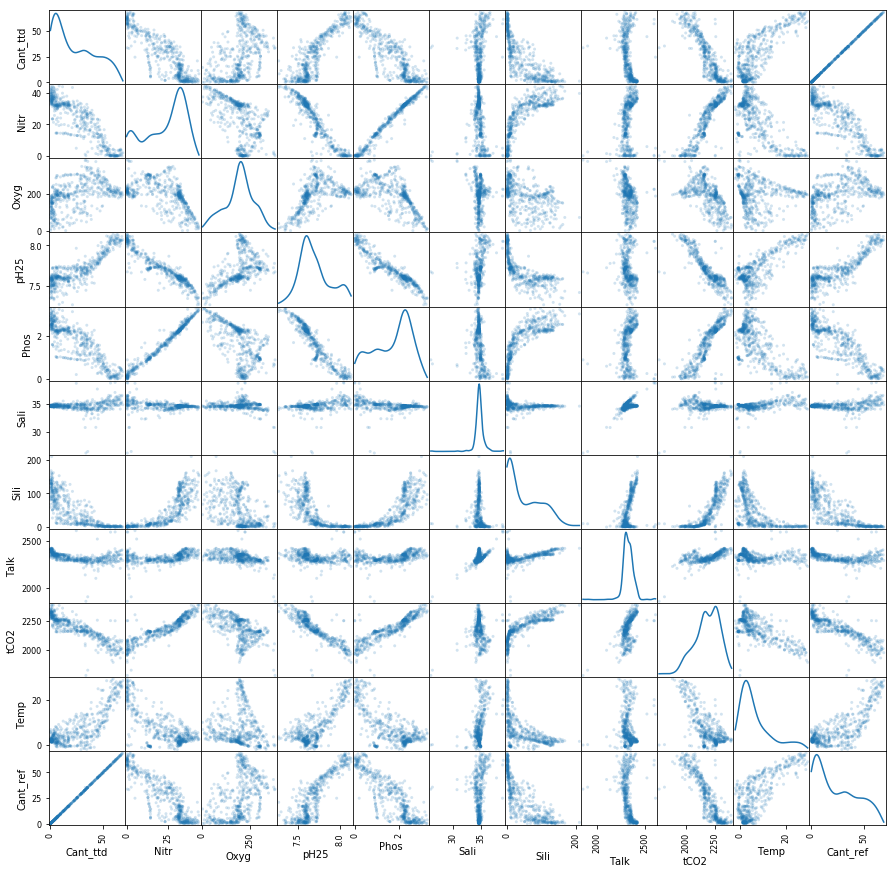

In [10]:
""" Analysis of raw dataset columns """

scatter_matrix(data_sample, alpha=0.2, figsize=(15, 15), diagonal='kde');

# Uncomment the following to save the plot
# plt.savefig(r"scatter_matrix_initial.png")

In [11]:
""" Analysis of calibrated distributions """

x_data = [
    'Cant_ttd', 'Nitr', 'Oxyg', 
    'pH25', 'Phos', 'Sali', 
    'Sili', 'Talk', 'Carb', 
    'Temp', 'Cant_ref'
]

y_data = [
    (data_sample['Cant_ttd'] - data_sample['Cant_ttd'].mean()) / (data_sample['Cant_ttd'].max() - data_sample['Cant_ttd'].min()), 
    (data_sample['Nitr'] - data_sample['Nitr'].mean()) / (data_sample['Nitr'].max() - data_sample['Nitr'].min()), 
    (data_sample['Oxyg'] - data_sample['Oxyg'].mean()) / (data_sample['Oxyg'].max() - data_sample['Oxyg'].min()), 
    (data_sample['pH25'] - data_sample['pH25'].mean()) / (data_sample['pH25'].max() - data_sample['pH25'].min()),
    (data_sample['Phos'] - data_sample['Phos'].mean()) / (data_sample['Phos'].max() - data_sample['Phos'].min()), 
    (data_sample['Sali'] - data_sample['Sali'].mean()) / (data_sample['Sali'].max() - data_sample['Sali'].min()), 
    (data_sample['Sili'] - data_sample['Sili'].mean()) / (data_sample['Sili'].max() - data_sample['Sili'].min()), 
    (data_sample['Talk'] - data_sample['Talk'].mean()) / (data_sample['Talk'].max() - data_sample['Talk'].min()),
    (data_sample['tCO2'] - data_sample['tCO2'].mean()) / (data_sample['tCO2'].max() - data_sample['tCO2'].min()), 
    (data_sample['Temp'] - data_sample['Temp'].mean()) / (data_sample['Temp'].max() - data_sample['Temp'].min()),
    (data_sample['Cant_ref'] - data_sample['Cant_ref'].mean()) / (data_sample['Cant_ref'].max() - data_sample['Cant_ref'].min())
]

n_boxes = 14

colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, n_boxes)]

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=2,
            line_width=1)
        )

fig.update_layout(
    yaxis=dict(
        range=[-1, 1],
        showgrid=True,
        zeroline=True,
        dtick=0.5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig.show()

In [12]:
""" Calculate and plot the correlations among features """

corr = data_cleaned.corr()

fig = go.Figure(
    data=go.Heatmap(
        x = [
            'Cant_ttd', 'Nitr', 'Oxyg', 
            'pH25', 'Phos', 'Sali', 'Sili', 
            'Talk', 'tCO2', 'Temp', 'Cant_ref'
        ],
        y = [
            'Cant_ttd', 'Nitr', 'Oxyg', 
            'pH25', 'Phos', 'Sali', 'Sili', 
            'Talk', 'tCO2', 'Temp', 'Cant_ref'
        ],
        z = corr,
        zmin = -1,
        zmax = 1,
        showscale = True,
        type = 'heatmap',
        colorscale = 'Viridis'
    )
)
fig.show()


We are now ready to create the bechmark model. To do so, we use all of the remaining features and a linear regression.

In [13]:
""" Selecting a fraction of the data to improve the model performance and define test and train """

data_for_model = data_cleaned.sample(frac = 0.1)

X = data_for_model
X = X.drop(columns=['Cant_ref'])
Y = data_for_model.Cant_ref

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
Cant_ttd_train = X_train.Cant_ttd
X_train = X_train.drop(columns=['Cant_ttd'])
Cant_ttd_test = X_test.Cant_ttd
X_test = X_test.drop(columns=['Cant_ttd'])


In [14]:
""" Benchmark model: linear regression with all features """

model = LinearRegression().fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
rsq = r2_score(y_test, y_pred_lr)
rms = sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
print('The squared R for the Linear Regressor model is', round(rsq, 2))
print('The root mean standard error for the Linear Regressor model is', round(rms, 2))
print('The mean absolute error error for the Linear Regressor model is', round(mae, 2))


The squared R for the Linear Regressor model is 0.91
The root mean standard error for the Linear Regressor model is 6.33
The mean absolute error error for the Linear Regressor model is 4.93


In [15]:
""" Compare the results of teh benchmark model with the Cant reference """

hist_data = [
    y_test[1:500],
    y_pred_lr[1:500]]

group_labels = ['Measurements', 'Benchmark Model']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig['layout']['xaxis'].update(
    title='Anthropogenic carbon (Cant)', 
    range=[0, 80], 
    dtick=5, 
    showgrid=False, 
    autorange=False)
fig['layout']['yaxis'].update(
    title='Density', 
    range=[0, 0.1], 
    dtick=0.02, 
    showgrid=False, 
    autorange=False)
fig.show()


In [16]:
""" Ridge linear regressor """

model = Ridge(alpha=1).fit(X_train, y_train)
y_pred_rr = model.predict(X_test)
rsq = r2_score(y_test, y_pred_rr)
rms = sqrt(mean_squared_error(y_test, y_pred_rr))
mae = mean_absolute_error(y_test, y_pred_rr)
print('The squared R for the Ridge Linear Regressor model is', round(rsq, 2))
print('The root mean standard error for the Ridge Linear Regressor model is', round(rms, 2))
print('The mean absolute error error for the Ridge Linear Regressor model is', round(mae, 2))


The squared R for the Ridge Linear Regressor model is 0.91
The root mean standard error for the Ridge Linear Regressor model is 6.33
The mean absolute error error for the Ridge Linear Regressor model is 4.93


In [17]:
""" Lasso linear regressor """

model = Lasso(alpha=1).fit(X_train, y_train)
y_pred_ll = model.predict(X_test)
rsq = r2_score(y_test, y_pred_ll)
rms = sqrt(mean_squared_error(y_test, y_pred_ll))
mae = mean_absolute_error(y_test, y_pred_ll)
print('The squared R for the Lasso Linear Regressor model is', round(rsq, 2))
print('The root mean standard error for the Lasso Linear Regressor model is', round(rms, 2))
print('The mean absolute error error for the Lasso Linear Regressor model is', round(mae, 2))


The squared R for the Lasso Linear Regressor model is 0.9
The root mean standard error for the Lasso Linear Regressor model is 6.57
The mean absolute error error for the Lasso Linear Regressor model is 5.16


In [18]:
""" Decision Tree Regressor """

model = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)
y_pred_dt = model.predict(X_test)
rsq = r2_score(y_test, y_pred_dt)
rms = sqrt(mean_squared_error(y_test, y_pred_dt))
mae = mean_absolute_error(y_test, y_pred_dt)
print('The squared R for the Decision Tree Regressor model is', round(rsq, 2))
print('The root mean standard error for the Decision Tree Regressor model is', round(rms, 2))
print('The mean absolute error error for the Decision Tree Regressor model is', round(mae, 2))


The squared R for the Decision Tree Regressor model is 0.98
The root mean standard error for the Decision Tree Regressor model is 2.62
The mean absolute error error for the Decision Tree Regressor model is 1.52


In [19]:
""" Random Forest regressor """

model = RandomForestRegressor(random_state = 0).fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
rsq = r2_score(y_test, y_pred_rf)
rms = sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
print('The squared R for the Random Forest Regressor model is', round(rsq, 2))
print('The root mean standard error for the Random Forest Regressor model is', round(rms, 2))
print('The mean absolute error error for the Random Forest Regressor model is', round(mae, 2))


The squared R for the Random Forest Regressor model is 0.99
The root mean standard error for the Random Forest Regressor model is 1.98
The mean absolute error error for the Random Forest Regressor model is 1.22


In [20]:
""" MLP Neural Network Regressor """

model = MLPRegressor(random_state = 0).fit(X_train, y_train)
y_pred_mp = model.predict(X_test)
rsq = r2_score(y_test, y_pred_mp)
rms = sqrt(mean_squared_error(y_test, y_pred_mp))
mae = mean_absolute_error(y_test, y_pred_mp)
print('The squared R for the MLP Neural Network Regressor model is', round(rsq, 2))
print('The root mean standard error for the MLP Neural Network Regressor model is', round(rms, 2))
print('The mean absolute error error for the MLP Neural Network Regressor model is', round(mae, 2))


The squared R for the MLP Neural Network Regressor model is 0.91
The root mean standard error for the MLP Neural Network Regressor model is 6.41
The mean absolute error error for the MLP Neural Network Regressor model is 4.77


In [21]:
""" LightGBM Regressor """    

params_lgb = {
    "objective" : "regression",
    "metric" : {"rmse"}
}
    
model_train = lgb.Dataset(
    X_train,
    y_train,
    feature_name=list(X_train.columns),
    free_raw_data=False
)

model_test = lgb.Dataset(
    X_test,
    y_test,
    feature_name=list(X_test.columns),
    reference=model_train,
    free_raw_data=False
)

evals_result = {}

lgbm_model = lgb.train(
    params_lgb,
    model_train,
    num_boost_round=800,
    valid_sets=[model_train, model_test],
    evals_result=evals_result,
    early_stopping_rounds=50,
    verbose_eval=100
)

y_pred_lg = lgbm_model.predict(X_test)
rsq = r2_score(y_test, y_pred_lg)
rms = sqrt(mean_squared_error(y_test, y_pred_lg))
mae = mean_absolute_error(y_test, y_pred_lg)
print('The squared R for the lightGBM Regressor model is', round(rsq, 2))
print('The root mean standard error for the lightGBM Regressor model is', round(rms, 2))
print('The mean absolute error error for the lightGBM Regressor model is', round(mae, 2))


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.40188	valid_1's rmse: 2.52592
[200]	training's rmse: 2.16957	valid_1's rmse: 2.3458
[300]	training's rmse: 2.02739	valid_1's rmse: 2.24752
[400]	training's rmse: 1.9223	valid_1's rmse: 2.1811
[500]	training's rmse: 1.83042	valid_1's rmse: 2.1263
[600]	training's rmse: 1.7622	valid_1's rmse: 2.09201
[700]	training's rmse: 1.69849	valid_1's rmse: 2.06162
[800]	training's rmse: 1.64102	valid_1's rmse: 2.03251
Did not meet early stopping. Best iteration is:
[800]	training's rmse: 1.64102	valid_1's rmse: 2.03251
The squared R for the lightGBM Regressor model is 0.99
The root mean standard error for the lightGBM Regressor model is 2.03
The mean absolute error error for the lightGBM Regressor model is 1.38


In [22]:
""" Plot model results versus the Cant measurements """

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_lr[1:500],
                         mode='markers',
                         name='linear regression'))
fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_rr[1:500],
                         mode='markers',
                         name='ridge regression'))
fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_ll[1:500],
                         mode='markers', 
                         name='lasso regression'))
fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_dt[1:500],
                         mode='markers', 
                         name='decision tree'))
fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_rf[1:500],
                         mode='markers', 
                         name='random forest'))
fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_mp[1:500],
                         mode='markers', 
                         name='neural network'))
fig.add_trace(go.Scatter(x=y_test[1:500], y=y_pred_lg[1:500],
                         mode='markers', 
                         name='lightGBM'))
fig['layout']['xaxis'].update(
    title='Anthropogenic carbon measured', 
    range=[0, 80], 
    dtick=20, 
    showgrid=False, 
    autorange=False)
fig['layout']['yaxis'].update(
    title='Anthropogenic carbon predicted', 
    range=[0, 80], 
    dtick=20, 
    showgrid=False, 
    autorange=False)
fig.update_traces(marker=dict(size=5))

fig.show()


In [23]:
""" Plot the error distributions of the three top performing models and the TTD """

hist_data = [
    y_pred_rf[1:500] - y_test[1:500],
    y_pred_mp[1:500] - y_test[1:500],
    y_pred_lg[1:500] - y_test[1:500],
    Cant_ttd_test[1:500] - y_test[1:500]]

group_labels = ['Random Forest', 'Neural Network', 'LightGBM', 'TTD']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig['layout']['xaxis'].update(
    title='Error (predicted - measured)', 
    range=[-20, 20], 
    dtick=5, 
    showgrid=False, 
    autorange=False)
fig['layout']['yaxis'].update(
    title='Density', 
    range=[0, 1], 
    dtick=0.1, 
    showgrid=False, 
    autorange=False)
fig.show()
